## Imports

In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

import joblib

## Global Variables

In [86]:
''' 

95 Percentile
BAC 1d 2.5%, 1hr 1%
CRM 1d 2.76%, 1hr 1%
IDEX 1d 10.8%, 1hr 4.15%
IYW 1d 1.5%, 1hr 0.697%
JEF 1d 2.5%, 1hr 1.1%
TSLA 1d 4.3%, 1hr 1.66%
VGT 1d 1.41% 1hr 0.686%
VHT 1d 1.24%, 1hr 0.59%

'''

interval = '60m' # time interval for data point
history = '2y' # time period for total history
perc_inc = 0.01 # 1% increase or more from interval to interval
symbol = 'CRM' # tech etf 

## Yahoo Finance

In [87]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = False
                      )

[*********************100%***********************]  1 of 1 completed


In [88]:
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-08-27 10:30:00-04:00,151.550003,151.729996,151.210007,151.360001,151.360001,0
2018-08-27 11:30:00-04:00,151.360001,152.300003,151.279999,151.399994,151.399994,551808
2018-08-27 12:30:00-04:00,151.390396,151.649994,151.270004,151.520004,151.520004,371862


In [89]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-08-26 15:30:00-04:00,270.899994,274.359985,268.869995,272.309998,272.309998,4305220
2020-08-27 09:30:00-04:00,267.000000,268.459991,260.839996,266.450012,266.450012,7144863
2020-08-27 10:30:09-04:00,266.274994,266.274994,266.274994,266.274994,266.274994,0


## Create Percent Change

In [90]:
stock_df['Percent Change'] = (stock_df.Close - stock_df.Open) / (stock_df.Open + 0.00001)
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Datetime,,,,,,,
2018-08-27 10:30:00-04:00,151.550003,151.729996,151.210007,151.360001,151.360001,0,-0.001254
2018-08-27 11:30:00-04:00,151.360001,152.300003,151.279999,151.399994,151.399994,551808,0.000264
2018-08-27 12:30:00-04:00,151.390396,151.649994,151.270004,151.520004,151.520004,371862,0.000856


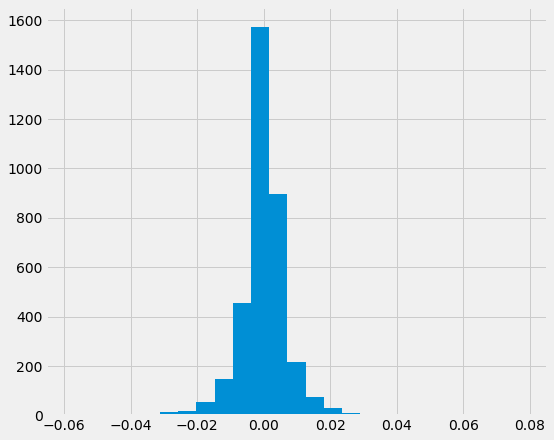

In [91]:
stock_df['Percent Change'].hist(bins=25);

In [92]:
stock_df['Percent Change'].quantile([0.95]) # 1 stdev from avg

0.95    0.010444
Name: Percent Change, dtype: float64

## High Minus Low Percent Change

In [93]:
stock_df['HL Percent Change'] = np.where(stock_df['Percent Change'] > 0
                                , (stock_df.High - stock_df.Low)/stock_df.Low
                                , (stock_df.Low - stock_df.High)/stock_df.High
                               )
stock_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change
Datetime,,,,,,,,
2018-08-27 10:30:00-04:00,151.550003,151.729996,151.210007,151.360001,151.360001,0,-0.001254,-0.003427
2018-08-27 11:30:00-04:00,151.360001,152.300003,151.279999,151.399994,151.399994,551808,0.000264,0.006742
2018-08-27 12:30:00-04:00,151.390396,151.649994,151.270004,151.520004,151.520004,371862,0.000856,0.002512
2018-08-27 13:30:00-04:00,151.480301,151.580002,151.017899,151.130005,151.130005,451423,-0.002312,-0.003708
2018-08-27 14:30:00-04:00,151.154999,151.562103,151.154999,151.419998,151.419998,424739,0.001753,0.002693


## Assign Direction

In [94]:
stock_df['Direction'] = np.where(stock_df['Percent Change'] > perc_inc
                                 , 1
                                 , 0
                                )

In [95]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change,Direction
Datetime,,,,,,,,,
2020-08-26 13:30:00-04:00,273.334991,273.668793,268.529999,270.709991,270.709991,5375253,-0.009604,-0.018777,0
2020-08-26 14:30:00-04:00,270.790009,270.959991,260.000000,270.869995,270.869995,6048327,0.000295,0.042154,0
2020-08-26 15:30:00-04:00,270.899994,274.359985,268.869995,272.309998,272.309998,4305220,0.005205,0.020419,0
2020-08-27 09:30:00-04:00,267.000000,268.459991,260.839996,266.450012,266.450012,7144863,-0.002060,-0.028384,0
2020-08-27 10:30:09-04:00,266.274994,266.274994,266.274994,266.274994,266.274994,0,0.000000,0.000000,0


## Shift Direction Column Up 1

Move decision column up by 1 cell so current hour of data will predict the next hour of data or whichever time frame interval is observed

In [96]:
direction = stock_df.Direction.values
print(f'Length Before: {len(direction)}')
direction = direction[1:len(direction)]
print(f'Length After: {len(direction)}')

Length Before: 3512
Length After: 3511


In [97]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
stock_df_one_off['Direction'] = direction
stock_df_one_off.shape

(3511, 9)

In [98]:
stock_df_one_off.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change,Direction
Datetime,,,,,,,,,
2020-08-26 12:30:00-04:00,274.640015,274.890015,272.530090,273.339996,273.339996,4856463,-0.004734,-0.008585,0
2020-08-26 13:30:00-04:00,273.334991,273.668793,268.529999,270.709991,270.709991,5375253,-0.009604,-0.018777,0
2020-08-26 14:30:00-04:00,270.790009,270.959991,260.000000,270.869995,270.869995,6048327,0.000295,0.042154,0
2020-08-26 15:30:00-04:00,270.899994,274.359985,268.869995,272.309998,272.309998,4305220,0.005205,0.020419,0
2020-08-27 09:30:00-04:00,267.000000,268.459991,260.839996,266.450012,266.450012,7144863,-0.002060,-0.028384,0


In [99]:
stock_df_one_off.Direction.value_counts()

0    3310
1     201
Name: Direction, dtype: int64

## Balance 1's and 0's

In [100]:
ones_count = stock_df_one_off['Direction'].value_counts()[1]
ones_count

201

In [101]:
stock_df_bal = stock_df_one_off.groupby('Direction').apply(lambda x: x.sample(n=ones_count)).reset_index(drop=True)
stock_df_bal.shape

(402, 9)

In [102]:
stock_df_bal['Direction'].value_counts() # try bootstrapping and upsampling 

1    201
0    201
Name: Direction, dtype: int64

## Check for NaN's

In [103]:
stock_df_bal.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Percent Change       0
HL Percent Change    0
Direction            0
dtype: int64

In [104]:
stock_df_bal.dropna(axis=0, inplace=True)

In [105]:
stock_df_bal.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Percent Change       0
HL Percent Change    0
Direction            0
dtype: int64

## Train Test Split

In [106]:
X = stock_df_bal.drop(columns=['Direction'])
y = stock_df_bal['Direction']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.2
                                                    , random_state = 42
                                                   )

## Grid Search

In [108]:
grid1={'bootstrap': [True, False]
       , 'n_estimators': [5, 25, 45, 65, 85, 105, 125]
       , 'max_depth': [1, 2, 3, 4, 5, 6]
       , 'max_features': [1, 2, 3, 4, 5, 6]
       , 'min_samples_leaf': [1, 2, 3, 4, 5]
       , 'min_samples_split': [2, 3, 4, 5, 6]
      }

rf_grid_search1 = GridSearchCV(estimator = RandomForestClassifier()
                               , param_grid = grid1
                               , cv = 7
                               , n_jobs = -1
                               , verbose = 1
                              )

rf_grid_search1.fit(X_train, y_train)

Fitting 7 folds for each of 12600 candidates, totalling 88200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 1448 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 4748 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6248 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7948 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9848 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 11948 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 14248 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 16748 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 19448 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 22348 tasks  

GridSearchCV(cv=7, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': [1, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [5, 25, 45, 65, 85, 105, 125]},
             verbose=1)

In [109]:
rf_grid_search1.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 5}

## Save Best Parameters

In [110]:
joblib.dump(rf_grid_search1.best_params_
            , 'rfc_1hr_CRM.pkl' # 1d or 1hr change ***
            , compress = 1
           )

['rfc_1hr_CRM.pkl']

## Load Best parameters

In [209]:
rfc = RandomForestClassifier(random_state = 42
                             , n_jobs = -1
                             , verbose = 1
                            ).set_params(**joblib.load('rfc_1hr_IDEX.pkl')) # 1d or 1hr change ***

## Random Forest Classifier

In [210]:
# rfc loaded from above
# rfc = RandomForestClassifier(bootstrap = True
#                              , n_estimators = 5 # how many trees, optimize using grid search   
#                              , random_state = 42
#                              , verbose = 1
#                              , n_jobs = -1 # uses all your processer cores
#                              , max_depth = 6 # height of tree
#                              , max_features = 3 # random sampling of features
#                              , min_samples_leaf = 2
#                              , min_samples_split = 2
#                              # need to tune n_estimators, n max_depth, max_features
#                             )

In [211]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


## Cross Val Score

In [212]:
cval = cross_val_score(rfc
                       , X_train
                       , y_train
                       , scoring='accuracy'
                       , cv=7
                      )

print(f'Cross-Validation Score: {np.mean(cval)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s


Cross-Validation Score: 0.6374549819927972


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_j

## Receiver Operating Characteristic (ROC) Curve

In [213]:
roc_score = roc_auc_score(y_test
                          , y_probs
                         )
roc_score

0.6724137931034483

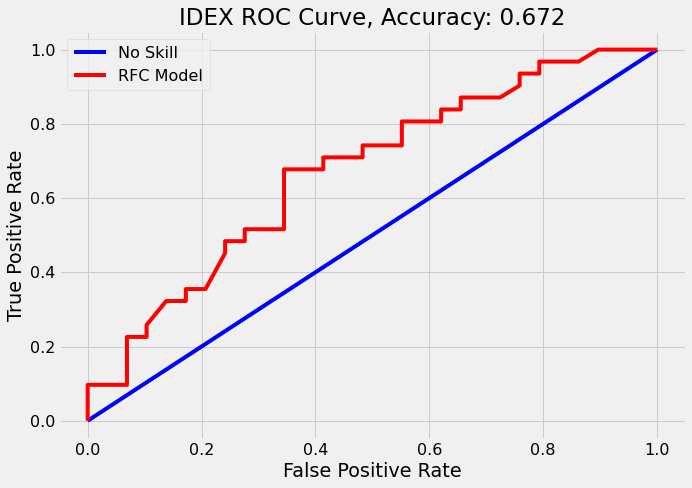

In [214]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y_test
                                  , [1 for _ in range(len(y_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y_test
                                    , y_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_score, 3)}')
plt.legend();

## Precision Recall Curve

In [215]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y_test
                                             , y_probs
                                            )

auc_score = auc(rf_recall, rf_prec)
auc_score

0.6788914921964834

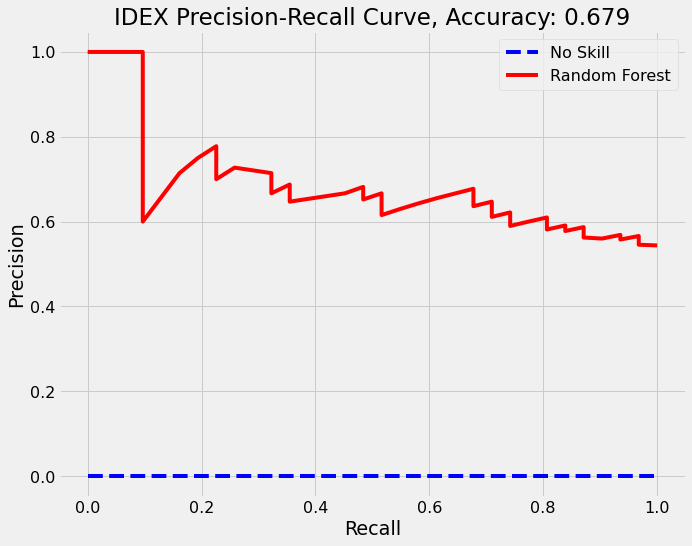

In [216]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc_score, 3)}')
plt.legend();

## Confusion Matrix

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


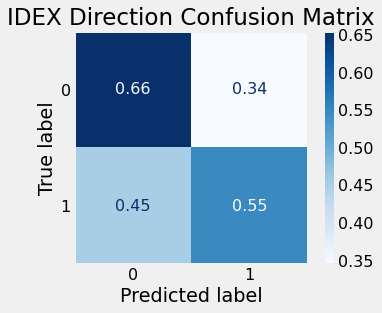

In [217]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap = plt.cm.Blues
                             , normalize = 'true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Direction Confusion Matrix');

## Feature Importances

In [218]:
features_df = pd.DataFrame({'Feature': X_train.columns
                            , 'Importances': rfc.feature_importances_
                           }).sort_values('Importances'
                                          , ascending=False
                                         )
features_df

,Feature,Importances
5,Volume,0.222338
0,Open,0.210995
6,Percent Change,0.194627
3,Close,0.120041
2,Low,0.092547
4,Adj Close,0.070236
7,HL Percent Change,0.049572
1,High,0.039644


## Make A Prediction

In [219]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change,Direction
Datetime,,,,,,,,,
2020-08-25 13:30:00-04:00,1.250,1.3000,1.25,1.285,1.285,1193258,0.028000,0.040000,0
2020-08-25 14:30:00-04:00,1.285,1.2893,1.27,1.275,1.275,154999,-0.007782,-0.014969,0
2020-08-25 14:36:28-04:00,1.270,1.2700,1.27,1.270,1.270,0,0.000000,0.000000,0


In [220]:
last = stock_df.drop(columns=['Direction']).iloc[-1]
last

Open                 1.27
High                 1.27
Low                  1.27
Close                1.27
Adj Close            1.27
Volume               0.00
Percent Change       0.00
HL Percent Change    0.00
Name: 2020-08-25 14:36:28-04:00, dtype: float64

In [221]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} for {round(perc_inc * 100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval for expected {round(perc_inc * 100, 1)}% increase.')

Sell or hold IDEX on the 60m interval for expected 4.2% increase.


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


Try Gradient Boosting: n_estimators, n_splits, n_depths, learning rate, etc...

### Make A Function